# Experiments

## Colab setup

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 1.2 MB/s 
     |████████████████████████████████| 3.5 MB 1.7 MB/s 


In [2]:
!pip install ogb
!pip install grandiso

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 4.6 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=f2b888dfd1c87ca4f68a5abd40967f764e6323fb7c545e59b8cfe968ca5f6af5
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for grandiso: filename=grandiso-2.1.1-py3-none-any.whl size=15159 sha256=a8a5d8e4b34baf75e10fabefabcb727f7279710931e2c6f3c884a95eb2506c1e
  Stored in directory: /root/.cache/pip/wheels/c4/a2/f8/9ed72d95be070220db1e6e0f7771e1044dd00daeca9b06bcc5
Successfully built grandiso


Loading drive:

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Mount the current directory
%cd /content/drive/My\ Drive//CS159_project/Graph_homomorphism/graph_homomorphism

Mounted at /content/drive
/content/drive/My Drive/CS159_project/Graph_homomorphism/graph_homomorphism


### imports

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform
from torch_geometric.datasets import TUDataset, ZINC
from ogb.graphproppred import PygGraphPropPredDataset
#import torch_geometric.utils as uts
#from torch_geometric.utils import remove_self_loops, to_undirected

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [5]:
# Graph utilities
import networkx as nx
import graph_encoding.encoding as encoding 


In [172]:
from importlib import reload 

encoding = reload(encoding)


## Helper functions

In [83]:
# set up embedding 

def add_testgraphs(encoded_data, limit_vertex = None,
            n_trees = 4, limit_trees = 10000,
            n_cycles = 4,limit_cycles = 10000, 
            n_cliques = 4, limit_cliques = 100):
    encoded_data.clear_all_testgraphs()

    encoded_data.add_single_vertex(limit = limit_vertex)
    encoded_data.add_trees(stop = n_trees, limit = limit_trees)
    encoded_data.add_cycles(stop = n_cycles, limit = limit_cycles)
    encoded_data.add_cliques(stop = n_cliques, limit = limit_cliques)
  

  

## Experiments: graph classification tasks

In [229]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [123]:
from torch._C import NoneType
# svm experiment

class SVM_experiment:
  def __init__(self):
      self.clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
      self.cv_scores = None
      self.num_cv = None
  def fit_cv_scores(self, X, y, num_cv = 5, scoring = 'accuracy'):
      self.num_cv = num_cv
      self.cv_scores = cross_val_score(self.clf, X, y, cv=num_cv, scoring= scoring)
  def plot_cv_results(self):
      width = 0.35
      labels = [f'G{n}' for n in range(1,self.num_cv+1)]
      fig = plt.figure()
      ax = fig.add_subplot()
      ax.bar(labels, self.cv_scores, width)
      ax.set_ylabel('Scores')
      ax.set_title('Cross validation scores for SVM')
      plt.axhline(y = self.cv_scores.mean(), c = 'black', linewidth = 0.7, 
            label = f'Err = {self.cv_scores.mean():.2f}' + u"\u00B1" + f'{self.cv_scores.std():.2f}')
      ax.legend()

      plt.show()
      print(f'Error = {self.cv_scores.mean():.2f}' + u"\u00B1" + f'{self.cv_scores.std():.2f}')


In [85]:
# Set up an experiment

def make_embedding(n_trees, limit_trees, n_cycles, limit_cycles,
                n_cliques, limit_cliques):
  encode_exp = lambda x: encode(x, limit_trees, n_trees,
                                n_cycles, limit_cycles,
                                n_cliques, limit_cliques)
  Encoded_Dataset = [encode_exp(data) for data in tqdm(dataset)]
  # labels
  y = np.array([data.pyg_graph().y[0,0].detach().numpy() for data in tqdm(Encoded_Dataset)])
  #vectors
  X = np.array([data.ghc_encoder(format = 'numpy')  for data in tqdm(Encoded_Dataset)])

  return [X, y, np.array([n_trees, limit_trees, n_cycles, limit_cycles,
                n_cliques, limit_cliques])]





### First experiment: MUTAG:

In [ ]:
# load the data:

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [ ]:
# pre-processing MUTAG
Encoded_Dataset = [encode(data) for data in tqdm(dataset)]

100%|██████████| 188/188 [00:00<00:00, 2890.32it/s]


In [ ]:
# get representation MUTAG
# labels
y = np.array([data.pyg_graph().y.detach().numpy() for data in Encoded_Dataset])
# vectors
X = np.array([data.ghc_encoder(format = 'numpy')  for data in tqdm(Encoded_Dataset)])
#%timeit Encoded_Dataset[0].ghc_encoder(format = 'numpy')

100%|██████████| 188/188 [00:01<00:00, 97.29it/s]


In [ ]:
y = y.reshape(188)

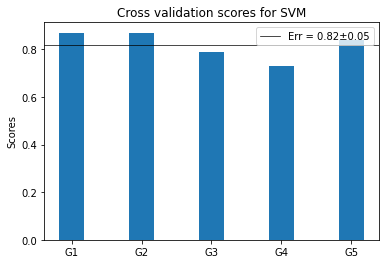

Error = 0.82±0.05


In [ ]:
# Run classifier - MUTAG

experiment = SVM_experiment()
experiment.fit_cv_scores(X, y, scoring='f1_weighted')
experiment.plot_cv_results()

### Experiment: "ogbg-molhiv" 

In [125]:
# setup the provided node encoder
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
emb_dim = 10
atom_encoder = AtomEncoder(emb_dim)
bond_encoder = BondEncoder(emb_dim)

class atom_transform(BaseTransform):
  def __call__(self, data):
    newdata = data.clone()
    newdata.x = atom_encoder(data.x)
    return newdata

transform = atom_transform()

In [129]:
# load the data 
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/', transform = transform)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[7]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of features: 10
Number of classes: 2

Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 10], y=[1, 1], num_nodes=18)


In [131]:
encoded_dataset = [encoding.grandEmbedding(data) for data in tqdm(dataset)]



  0%|          | 0/41127 [00:00<?, ?it/s]

  0%|          | 72/41127 [00:00<01:02, 655.32it/s]

  0%|          | 169/41127 [00:00<00:49, 830.80it/s]

  1%|          | 274/41127 [00:00<00:44, 927.17it/s]

  1%|          | 368/41127 [00:00<00:48, 842.14it/s]

  1%|          | 461/41127 [00:00<00:46, 871.18it/s]

  1%|▏         | 573/41127 [00:00<00:42, 950.00it/s]

  2%|▏         | 670/41127 [00:00<00:43, 921.26it/s]

  2%|▏         | 763/41127 [00:00<00:47, 849.48it/s]

  2%|▏         | 850/41127 [00:01<00:54, 743.71it/s]

  2%|▏         | 928/41127 [00:01<00:55, 724.83it/s]

  3%|▎         | 1053/41127 [00:01<00:46, 861.20it/s]

  3%|▎         | 1156/41127 [00:01<00:44, 906.00it/s]

  3%|▎         | 1251/41127 [00:01<00:43, 918.13it/s]

  3%|▎         | 1358/41127 [00:01<00:41, 960.70it/s]

  4%|▎         | 1456/41127 [00:01<00:42, 941.46it/s]

  4%|▍         | 1569/41127 [00:01<00:39, 994.81it/s]

  4%|▍         | 1670/41127 [00:01<00:44, 890.16it/s]

  4%|▍         | 1775/41127 [00

In [132]:
def single_graph_data(i, encoder, file_name,
                      n_cliques, n_cycles, n_trees):
  add_graphs = lambda x: add_testgraphs(encoded_data = x,                                           n_trees= n_trees, limit_trees= 10000,                                              n_cycles=n_cycles, limit_cycles = 10000,
                                      n_cliques= n_cliques, limit_cliques=100)
  add_to_Dataset = [add_graphs(data) for data in tqdm(encoded_dataset)]
  # labels
  y = np.array([data.pyg_graph().y[0,0].detach().numpy() for data in tqdm(encoded_dataset)])
  #vectors
  X = np.array([encoder(data)  for data in tqdm(encoded_dataset)])
  nums = np.array([n_cliques, n_cycles, n_trees])
  np.save(file_name +f'{i}_X.npy', X )
  np.save(file_name + f'{i}_y.npy', y )
  np.save(file_name +f'{i}_nums.npy', nums)


def gather_graph_data(encoder, file_name, cliques_limit = 5, 
                      cycles_limit = 6, trees_limit = 6):
  i = 0
  for n_cliques in range(4,cliques_limit):
    for n_cycles in range(3,cycles_limit):
        for n_trees in range(2, trees_limit):

          add_graphs = lambda x: add_testgraphs(encoded_data = x, 
                                                n_trees= n_trees, limit_trees= 10000,
                                                n_cycles=n_cycles, limit_cycles = 10000,
                                                n_cliques= n_cliques, limit_cliques=100)
          add_to_Dataset = [add_graphs(data) for data in tqdm(encoded_dataset)]
          # labels
          y = np.array([data.pyg_graph().y[0,0].detach().numpy() for data in tqdm(encoded_dataset)])
          #vectors
          X = np.array([encoder(data)  for data in tqdm(encoded_dataset)])
          nums = np.array([n_cliques, n_cycles, n_trees])
          np.save(file_name +f'{i}_X.npy', X )
          np.save(file_name + f'{i}_y.npy', y )
          np.save(file_name +f'{i}_nums.npy', nums)
          i+=1   


In [73]:
# GHC:
file_name = 'Experiments/ogbg-molhiv/GHC_encoded_data/experiment_'
encdoer = lambda x: x.ghc_encoder(format = 'numpy')
gather_graph_data(encdoer, file_name)

In [ ]:
# GHC with augmentation:
file_name = 'Experiments/ogbg-molhiv/ghc_aug/experiment_'
ghc = lambda x: x.ghc_encoder(format = 'numpy')
num_enc = lambda x: x.num_encoder(format = 'numpy')
encoder = lambda x: np.concatenate((ghc(x),num_enc(x)), axis = 0)
gather_graph_data(encdoer, file_name)

In [134]:
# Lagrangian with augmentation:
file_name = 'Experiments/ogbg-molhiv/lagrangian_aug/experiment_'
raw_encoder = lambda x: x.lagrangian_encoder(format = 'numpy')
num_enc = lambda x: x.num_encoder(format = 'numpy')
encoder = lambda x: np.concatenate((raw_encoder(x),num_enc(x)), axis = 0)
single_graph_data(800, encoder, file_name,
                  n_cliques = 4, n_cycles = 5, n_trees = 2)
#gather_graph_data(encdoer, file_name)

100%|██████████| 41127/41127 [06:54<00:00, 99.15it/s]


In [ ]:
# calculate GHC components_legacy
#i = 0
#for n_cliques in range(4,5):
 # for n_cycles in range(3,6):
  #    for n_trees in range(2, 6):

   #     add_graphs = lambda x: add_testgraphs(encoded_data = x, 
    #                                          n_trees= n_trees, limit_trees= 10000,
     #                                         n_cycles=n_cycles, limit_cycles = 10000,
      #                                        n_cliques= n_cliques, limit_cliques=100)
       # add_to_Dataset = [add_graphs(data) for data in tqdm(encoded_dataset)]
        # labels
        #y = np.array([data.pyg_graph().y[0,0].detach().numpy() for data in tqdm(encoded_dataset)])
        #vectors
        #X = np.array([data.ghc_encoder(format = 'numpy')  for data in tqdm(encoded_dataset)])
        #nums = np.array([n_cliques, n_cycles, n_trees])
        #np.save(f'Experiments/ogbg-molhiv/experiment_{i}_X.npy', X )
        #np.save(f'Experiments/ogbg-molhiv/experiment_{i}_y.npy', y )
        #np.save(f'Experiments/ogbg-molhiv/experiment_{i}_nums.npy', nums)
        #i+=1          




In [43]:
j = 0
for n_cliques in range(4,5):
  for n_cycles in range(3,6):
      for n_trees in range(2, 6):
        print([j, n_cliques, n_cycles, n_trees])
        j+=1

[0, 4, 3, 2]
[1, 4, 3, 3]
[2, 4, 3, 4]
[3, 4, 3, 5]
[4, 4, 4, 2]
[5, 4, 4, 3]
[6, 4, 4, 4]
[7, 4, 4, 5]
[8, 4, 5, 2]
[9, 4, 5, 3]
[10, 4, 5, 4]
[11, 4, 5, 5]


#### Evaluation

In [135]:
def set_up_experiment(X_train, y_train, X_valid, y_valid):
    C_array = [10**3, 10**2, 10** 1, 10**0, 10**-1, 10**-2, 10**-3]

    max_score = 0
    C_max = 0
    for C in C_array:
        clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C = 1, probability = True, random_state=42))
        # fit model
        clf.fit(X_train, y_train)
        # Calculate predictions 
        y_valid_pred = clf.predict_proba(X_valid)

        y_pred_valid = y_valid_pred[:,1].reshape(4113,1)
        y_true_valid = y_valid.reshape(4113,1)

        input_valid_dict = {'y_true': y_true_valid, 'y_pred': y_pred_valid}
        valid_score = evaluator.eval(input_valid_dict)['rocauc']

        if valid_score > max_score:
            max_score = valid_score
            C_max = C
        return {'max_score': max_score, 'C_max' : C_max}

In [136]:
from ogb.graphproppred import Evaluator

evaluator = Evaluator(name = 'ogbg-molhiv')
print(evaluator.expected_input_format) 
print(evaluator.expected_output_format)  

==== Expected input format of Evaluator for ogbg-molhiv
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_graph, num_task)
- y_pred: numpy ndarray or torch tensor of shape (num_graph, num_task)
where y_pred stores score values (for computing AUC score),
num_task is 1, and each row corresponds to one graph.
nan values in y_true are ignored during evaluation.

==== Expected output format of Evaluator for ogbg-molhiv
{'rocauc': rocauc}
- rocauc (float): ROC-AUC score averaged across 1 task(s)



In [25]:
#usual GHC
X_list = [np.load(f'Experiments/ogbg-molhiv/GHC_encoded_data/experiment_{i}_X.npy') for i in range(12)]
y_list = [np.load(f'Experiments/ogbg-molhiv/GHC_encoded_data/experiment_{i}_y.npy') for i in range(12)]
nums_list = [np.load(f'Experiments/ogbg-molhiv/GHC_encoded_data/experiment_{i}_nums.npy') for i in range(12)]


In [97]:
# GHC augmented
X_list = [np.load(f'Experiments/ogbg-molhiv/ghc_aug/experiment_{i}_X.npy') for i in range(12)]
y_list = [np.load(f'Experiments/ogbg-molhiv/ghc_aug/experiment_{i}_y.npy') for i in range(12)]
nums_list = [np.load(f'Experiments/ogbg-molhiv/ghc_aug/experiment_{i}_nums.npy') for i in range(12)]


In [98]:
X_list[0].shape, len(y_list), len(nums_list)

((41127, 11), 12, 12)

In [144]:
# Using the given train-test split

split_idx = dataset.get_idx_split()

train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx  = split_idx["test"]

In [100]:
list(map(lambda x: x.shape, X_list))

[(41127, 11),
 (41127, 22),
 (41127, 33),
 (41127, 55),
 (41127, 22),
 (41127, 33),
 (41127, 44),
 (41127, 66),
 (41127, 33),
 (41127, 44),
 (41127, 55),
 (41127, 77)]

In [101]:
nums_list[11]

array([4, 5, 5])

In [ ]:
def calculate_score_SVM(i):
  X = X_list[i]
  y = y_list[i]

  X_train , y_train = X[train_idx], y[train_idx]
  X_valid , y_valid = X[valid_idx], y[valid_idx]
  X_test , y_test = X[test_idx], y[test_idx]

  result_dict = set_up_experiment(X_train, y_train, X_valid, y_valid)

  best_val_score = result_dict['max_score']
  C_max = result_dict['C_max']

  clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C = C_max, probability = True, random_state=42))
  # fit model
  clf.fit(X_train, y_train)

  # calculate test auroc
  y_test_pred = clf.predict_proba(X_test)
  y_pred_test = y_test_pred[:,1].reshape(4113,1)
  y_true_test = y_test.reshape(4113,1)

  input_test_dict = {'y_true': y_true_test, 'y_pred': y_pred_test}
  test_score = evaluator.eval(input_test_dict)['rocauc']

  # calculate train auroc
  y_train_pred = clf.predict_proba(X_train)
  y_pred_train = y_train_pred[:,1].reshape(32901,1)
  y_true_train = y_train.reshape(32901,1)
  
  input_train_dict = {'y_true': y_true_train, 'y_pred': y_pred_train}
  train_score = evaluator.eval(input_train_dict)['rocauc']

  return [train_score, test_score, best_val_score, C_max]


In [ ]:
for i in tqdm(range(12)): 
  svm_data = calculate_score_SVM(i)
  svm_data_array = np.array(svm_data)
  np.save(f'Experiments/ogbg-molhiv/svm_data_{i}.npy', svm_data_array)

100%|██████████| 12/12 [3:50:44<00:00, 1153.69s/it]


In [142]:
# load single experiment Lag
X = np.load(f'Experiments/ogbg-molhiv/lagrangian_aug/experiment_800_X.npy')
y = np.load(f'Experiments/ogbg-molhiv/lagrangian_aug/experiment_800_y.npy')
nums_list = np.load(f'Experiments/ogbg-molhiv/lagrangian_aug/experiment_800_nums.npy')

In [143]:
X.shape, y.shape, nums_list

((41127, 33), (41127,), array([4, 5, 2]))

#### Random forest eval:

In [102]:
# try PCA before evaluation
from sklearn.decomposition import PCA, IncrementalPCA

One random forest measuremnt:

In [169]:
def molhiv_calculate_score_single_forest(X, y):
  X_train , y_train = X[train_idx], y[train_idx]
  X_valid , y_valid = X[valid_idx], y[valid_idx]
  X_test , y_test = X[test_idx], y[test_idx]

  # preprocess pca
  if i > 1:
    pca = PCA(n_components = 20)
  else:
    pca = PCA()
  pca.fit(X_train, y_train)

  X_train_new = pca.transform(X_train)
  X_valid_new = pca.transform(X_valid)
  X_test_new = pca.transform(X_test)

  clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
  # fit model
  clf.fit(X_train_new, y_train)
  
  # calculate test auroc
  y_test_pred = clf.predict_proba(X_test_new)
  y_pred_test = y_test_pred[:,1].reshape(4113,1)
  y_true_test = y_test.reshape(4113,1)

  input_test_dict = {'y_true': y_true_test, 'y_pred': y_pred_test}
  test_score = evaluator.eval(input_test_dict)['rocauc']

  # calculate valid auroc
  y_valid_pred = clf.predict_proba(X_valid_new)
  y_pred_valid = y_valid_pred[:,1].reshape(4113,1)
  y_true_valid = y_valid.reshape(4113,1)

  input_valid_dict = {'y_true': y_true_valid, 'y_pred': y_pred_valid}
  valid_score = evaluator.eval(input_valid_dict)['rocauc']

  # calculate train auroc
  y_train_pred = clf.predict_proba(X_train_new)
  y_pred_train = y_train_pred[:,1].reshape(32901,1)
  y_true_train = y_train.reshape(32901,1)
  
  input_train_dict = {'y_true': y_true_train, 'y_pred': y_pred_train}
  train_score = evaluator.eval(input_train_dict)['rocauc']

  return [train_score, valid_score, test_score]

In [170]:
def molhiv_calculate_score_random_forest(i):
  X = X_list[i]
  y = y_list[i]

  return molhiv_calculate_score_single_forest(X,y)

In [105]:
# run random forest
for i in tqdm(range(12)): 
  random_forest_data = molhiv_calculate_score_random_forest(i)
  random_forest_data_array = np.array(random_forest_data)
  np.save(f'Experiments/ogbg-molhiv/random_forest_scores_{i}.npy', random_forest_data_array)

100%|██████████| 12/12 [04:23<00:00, 21.93s/it]


### Experiment: NCI-1

In [212]:
class nci1_transform(BaseTransform):
   def __call__(self, data):
     new_data = data.clone()
     w = torch.rand(37)
     new_data.x = torch.unsqueeze(torch.tensordot(data.x, w,  dims=([1], [0])),1)
     return new_data


In [211]:
a = torch.tensordot(torch.tensor([[1,0],[0,1]]), torch.tensor([0,1]),  dims=([1], [0]))
torch.unsqueeze(a,1)

tensor([[0],
        [1]])

In [213]:
transform = nci1_transform()

In [214]:
# load the data:

dataset = TUDataset(root='data/TUDataset', name='NCI1', transform=transform)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: NCI1(4110):
Number of graphs: 4110
Number of features: 1
Number of classes: 2

Data(edge_index=[2, 42], x=[21, 1], y=[1])


In [215]:
encoded_dataset = [encoding.grandEmbedding(data) for data in tqdm(dataset)]

100%|██████████| 4110/4110 [00:00<00:00, 4253.96it/s]


In [216]:
encoded_dataset[2].clear_all_testgraphs()
Cycl = [encoding.testGraph(graph = nx.cycle_graph(i), graph_name=f'c_{i}') for i in range(2,10)]
[encoded_dataset[2].ghc_agg(c) for c in Cycl]


[tensor([12.7721]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.1062]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.])]

In [255]:
encoded_dataset[0].pyg_graph().x[0]

tensor([0.4988])

In [158]:
f = torch.zeros(1)
torch.stack((torch.tensor([0.]), torch.tensor([70.4945])))

tensor([[ 0.0000],
        [70.4945]])

In [277]:
def TU_graph_data(i, encoder, file_name,
                      n_cliques, n_cycles, n_trees):
  add_graphs = lambda x: add_testgraphs(encoded_data = x,                                           n_trees= n_trees, limit_trees= 10000,                                              n_cycles=n_cycles, limit_cycles = 10000,
                                      n_cliques= n_cliques, limit_cliques=100)
  add_to_Dataset = [add_graphs(data) for data in tqdm(encoded_dataset)]
  # labels
  y = np.array([data.pyg_graph().y.detach().numpy() for data in tqdm(encoded_dataset)])
  #vectors
  X = np.array([encoder(data)  for data in tqdm(encoded_dataset)])
  nums = np.array([n_cliques, n_cycles, n_trees])
  np.save(file_name +f'{i}_X.npy', X )
  np.save(file_name + f'{i}_y.npy', y )
  np.save(file_name +f'{i}_nums.npy', nums)

In [218]:
# ghc:
file_name = 'Experiments/NCI1/ghc/experiment_'
ghc_encoder = lambda x: x.ghc_encoder(format = 'numpy')
#num_enc = lambda x: x.num_encoder(format = 'numpy')
#encoder = lambda x: np.concatenate((raw_encoder(x),num_enc(x)), axis = 0)
TU_graph_data(800, ghc_encoder, file_name,
                  n_cliques = 6, n_cycles = 6, n_trees = 8)
#gather_graph_data(encdoer, file_name)

100%|██████████| 4110/4110 [13:21<00:00,  5.13it/s]


In [ ]:
# Lagrangian gather data:
file_name = 'Experiments/NCI1/ghc/experiment_'
ghc_encoder = lambda x: x.lagrangian_aug(format = 'numpy')
#num_enc = lambda x: x.num_encoder(format = 'numpy')
#encoder = lambda x: np.concatenate((raw_encoder(x),num_enc(x)), axis = 0)
TU_graph_data(800, ghc_encoder, file_name,
                  n_cliques = 6, n_cycles = 6, n_trees = 8)
#gather_graph_data(encdoer, file_name)
  for n_cliques in range(4,cliques_limit):
    for n_cycles in range(3,cycles_limit):
        for n_trees in range(2, trees_limit):

In [256]:
encoded_dataset[0].clear_all_testgraphs()
encoded_dataset[0].add_cliques(stop =6)
encoded_dataset[0].add_cycles(stop =6)
encoded_dataset[0].add_trees(stop =8)

encoded_dataset[0].ghc_encoder()


tensor([4.2804e-08, 9.5694e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2058e-04, 0.0000e+00,
        8.6364e+00, 2.2236e-04, 1.5697e+00, 5.0725e+00, 8.9654e-05, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.3470e-04, 6.4115e-04, 0.0000e+00, 5.7730e-04,
        4.0897e+00, 4.7723e-04, 5.9186e-04, 1.2507e+01, 3.2973e+00])

In [272]:
# load single experiment Lag
X = np.load(f'Experiments/NCI1/lagrangian_aug/experiment_800_X.npy')
y = np.load(f'Experiments/NCI1/lagrangian_aug/experiment_800_y.npy')
nums = np.load(f'Experiments/NCI1/lagrangian_aug/experiment_800_nums.npy')

In [264]:
# load single experiment ghc
X = np.load(f'Experiments/NCI1/ghc/experiment_800_X.npy')
y = np.load(f'Experiments/NCI1/ghc/experiment_800_y.npy')
nums = np.load(f'Experiments/NCI1/ghc/experiment_800_nums.npy')

In [273]:
y = y.reshape(4110,)

In [274]:
X.shape, y.shape

((4110, 1064), (4110,))

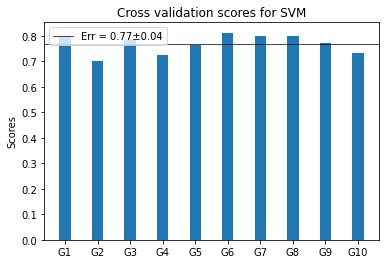

Validation error = 0.77±0.04


In [275]:
# calculate scores

#clf = make_pipeline(StandardScaler(), SVC(random_state=42, C = 100))
#clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
clf = make_pipeline(StandardScaler(), PCA(n_components = 100), 
                    RandomForestClassifier(random_state=42))

cv = 10
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
 
width = 0.35
labels = [f'G{n}' for n in range(1,cv+1)]
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(labels, scores, width)
ax.set_ylabel('Scores')
ax.set_title('Cross validation scores for SVM')
plt.axhline(y = scores.mean(), c = 'black', linewidth = 0.7, 
            label = f'Err = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')
ax.legend()

plt.show()
print(f'Validation error = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [261]:
pca = PCA(n_components = 100)
pca.fit(X_train, y_train)

X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)

#clf = make_pipeline(StandardScaler(), SVC(random_state=42, C = 100))
clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
# fit model
clf.fit(X_train_new, y_train)

train_score = clf.score(X_train_new, y_train)
test_score = clf.score(X_test_new, y_test)

In [262]:
test_score, train_score

(0.816147859922179, 0.9983776768332252)